
# CardiVascular Disease Prediction & Diagnosis Using Bi-LSTM with Explainability AI


## Dataset Column Description:
    age: in years
    sex: (1 = male; 0 = female)
    cp: chest pain type
    trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    chol: serum cholestoral in mg/dl
    fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    restecg: resting electrocardiographic results
    thalach: maximum heart rate achieved
    exang: exercise induced angina (1 = yes; 0 = no)
    oldpeak: ST depression induced by exercise relative to rest
    slope: the slope of the peak exercise ST segment
    ca: number of major vessels (0-3) colored by flourosopy
    thal-- 
       | Value 0: NULL (dropped from the dataset previously) 
       | Value 1: fixed defect (no blood flow in some part of the heart) 
       | Value 2: normal blood flow 
       | Value 3: reversible defect (a blood flow is observed but it is not normal)

    target 1 or 0

## Context:
    This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. 
    In particular, the Cleveland database is the only one that has been used by ML researchers to this date. 
    The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.
    Dataset source: https://archive.ics.uci.edu/ml/datasets/Heart+Disease


## Table of contents
    Imports Libraries
    Loading and reading dataset
    Data Description
    Exploratory Data Analysis
    Data Visualization
    Data Pre-processing
    Logistic Regression
    Conclusion

### 1. Importing libraries

In [48]:
import sdv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split
%matplotlib inline

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Input, Lambda, Dropout
from tensorflow.keras.optimizers import Adam

### 2. Load and reading CVD dataset

In [49]:
df = pd.read_csv('C:/Users/LENOVO/Downloads/cvd_dataset.csv')

In [50]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


### 3. Dataset Description

#### Describe
    There has been lot of confusion about the meta data, as there are various different meta data available out there. Over here below I have got the two most used meta data mentioned below. So we are going to follow the second description.

##### 1 - description

    It's a clean, easy to understand set of data. However, the meaning of some of the column headers are not obvious. Here's what they mean,
    •    age: The person's age in years
    •    sex: The person's sex (1 = male, 0 = female)
    •    cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
    •    trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
    •    chol: The person's cholesterol measurement in mg/dl
    •    fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
    •    restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
    •    thalach: The person's maximum heart rate achieved
    •    exang: Exercise induced angina (1 = yes; 0 = no)
    •    oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
    •    slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
    •    ca: The number of major vessels (0-3)
    •    thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
    •    target: Heart disease (0 = no, 1 = yes)
    
##### 2 - description

    cp: chest pain type
    -- Value 0: asymptomatic
    -- Value 1: atypical angina
    -- Value 2: non-anginal pain
    -- Value 3: typical angina

    restecg: resting electrocardiographic results
    -- Value 0: showing probable or definite left ventricular hypertrophy by Estes' criteria
    -- Value 1: normal
    -- Value 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

    slope: the slope of the peak exercise ST segment
    0: downsloping; 1: flat; 2: upsloping

    thal: Results of the blood flow observed via the radioactive dye.

    Value 0: NULL (dropped from the dataset previously)
    Value 1: fixed defect (no blood flow in some part of the heart)
    Value 2: normal blood flow
    Value 3: reversible defect (a blood flow is observed but it is not normal)
    This feature and the next one are obtained through a very invasive process for the patients. 
    But, by themselves, they give a very good indication of the presence of a heart disease or not.

    target (maybe THE most important feature): 0 = disease, 1 = no disease

    A few more things to consider:
    data #93, 139, 164, 165 and 252 have ca=4 which is incorrect. In the original Cleveland dataset they are NaNs (so they should be removed)
    data #49 and 282 have thal = 0, also incorrect. They are also NaNs in the original dataset.

    I'll copy a sentence so you get more insight about the "thal" column (thal is for Thalium, a radioactive tracer injected during a stress test):
    --Nuclear stress testing requires the injection of a tracer, commonly technicium 99M (Myoview or Cardiolyte), which is then taken up by healthy, viable myocardial cells. A camera (detector) is used afterwards to image the heart and compare segments. A coronary stenosis is detected when a myocardial segment takes up the nuclear tracer at rest, but not during cardiac stress. This is called a "reversible defect." Scarred myocardium from prior infarct will not take up tracer at all and is referred to as a "fixed defect." --

    You can check all of this by comparing the Kaggle and the UCI datasets. Feel free to ask/correct/comment/say hi.

    To open a .data file, change the extension to a .txt and then open it with excel or similars.

    You're welcome!

In [51]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [53]:
df.count()

age         303
sex         303
cp          303
trestbps    303
chol        303
fbs         303
restecg     303
thalach     303
exang       303
oldpeak     303
slope       303
ca          303
thal        303
target      303
dtype: int64

In [54]:
duplicates = df.duplicated()
# Print the rows with duplicates
print(df[duplicates])

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
164   38    1   2       138   175    0        1      173      0      0.0   

     slope  ca  thal  target  
164      2   4     2       1  


In [55]:
df = df.drop_duplicates(keep='first')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [56]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

<AxesSubplot: title={'center': 'Finding Null Values Using Heatmap\n'}>

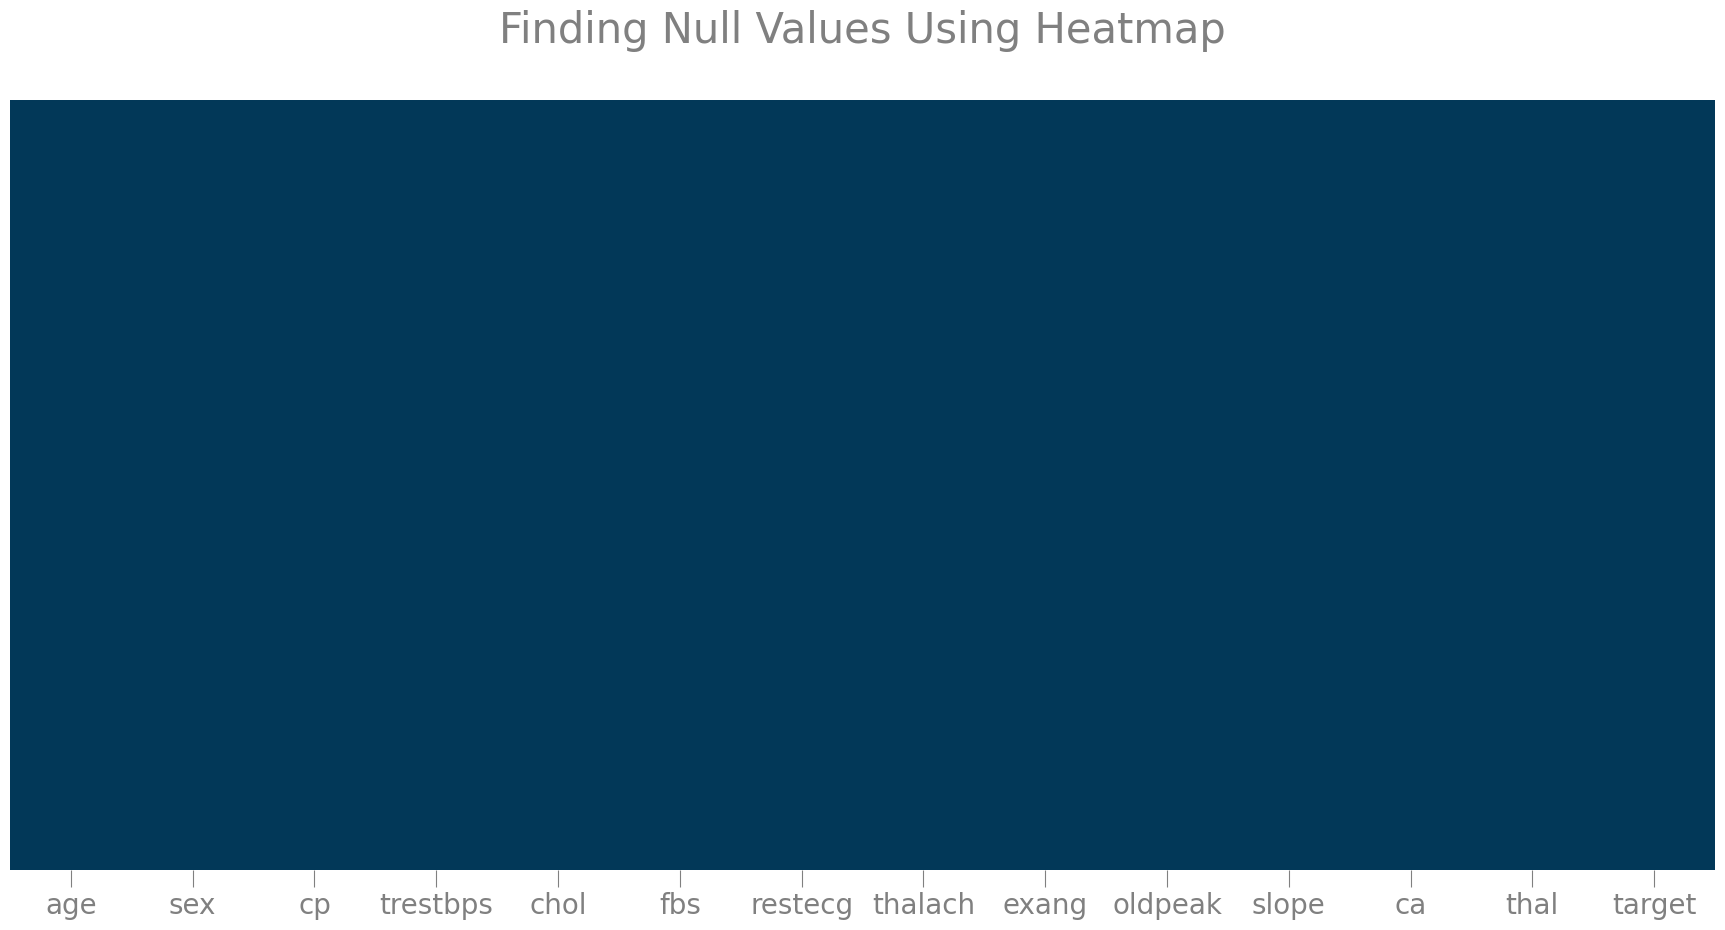

In [57]:
# visualizing null values if it exists
plt.figure(figsize=(22,10))

plt.xticks(size=20,color='grey')
plt.tick_params(size=12,color='grey')

plt.title('Finding Null Values Using Heatmap\n',color='grey',size=30)

sns.heatmap(df.isnull(),
            yticklabels=False,
            cbar=False,
            cmap='PuBu_r',
            )

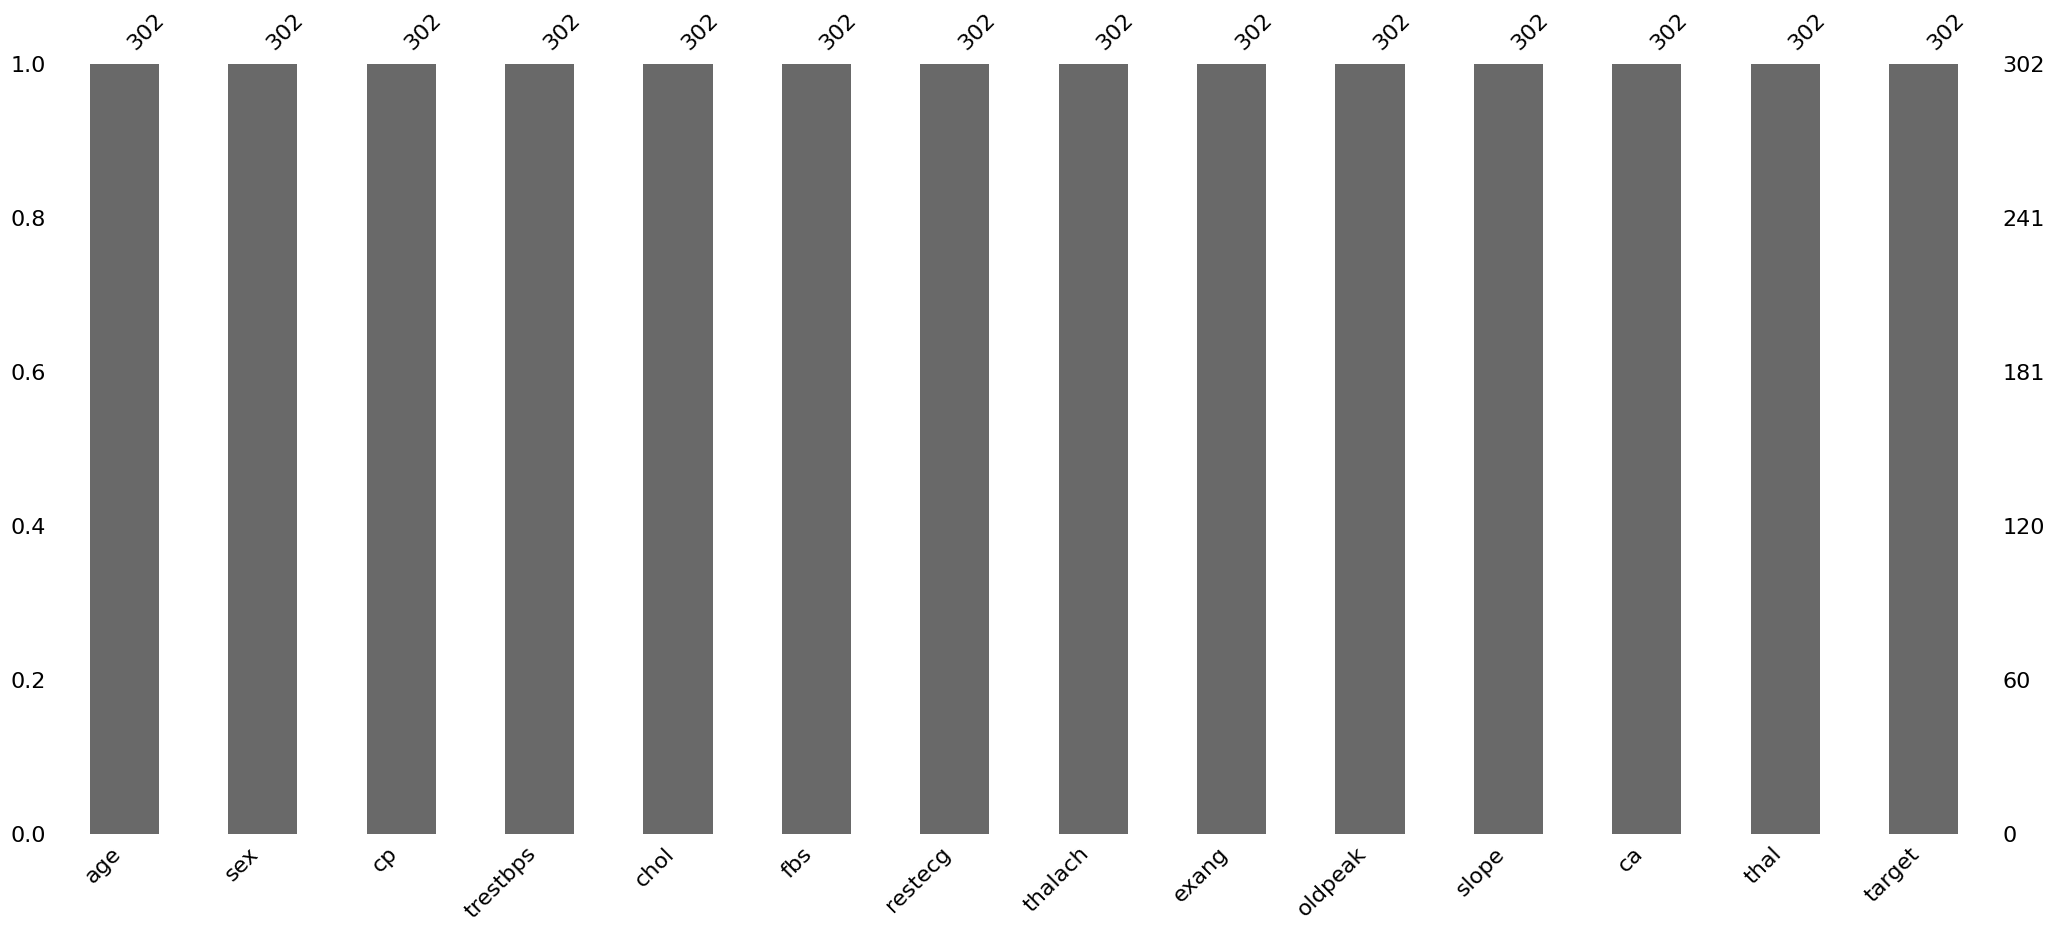

In [58]:
### using missingno library to visualize null values
#msno.matrix(df)
msno.bar(df)
plt.show()

In [59]:
import ydata_profiling as pp
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [60]:
# Split the original data into train and test sets
# the test and val data will be used to test and evalutae the model
# the train data will be used to train the model
X = df.iloc[:,0:13]  #independent columns
y = df.iloc[:,-1]    #target column i.e price range
X_train, X_dtest, y_train, y_dtest = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the test set into test and validation sets (50% test, 50% validation)
X_dtest, X_val, y_dtest, y_val = train_test_split(X_dtest, y_dtest, test_size=0.5, random_state=42)

In [61]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import TVAESynthesizer

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df)
metadata.validate()

In [62]:
python_dict = metadata.to_dict()
python_dict

{'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1',
 'columns': {'age': {'sdtype': 'numerical'},
  'sex': {'sdtype': 'numerical'},
  'cp': {'sdtype': 'numerical'},
  'trestbps': {'sdtype': 'numerical'},
  'chol': {'sdtype': 'numerical'},
  'fbs': {'sdtype': 'numerical'},
  'restecg': {'sdtype': 'numerical'},
  'thalach': {'sdtype': 'numerical'},
  'exang': {'sdtype': 'numerical'},
  'oldpeak': {'sdtype': 'numerical'},
  'slope': {'sdtype': 'numerical'},
  'ca': {'sdtype': 'numerical'},
  'thal': {'sdtype': 'numerical'},
  'target': {'sdtype': 'numerical'}}}

In [63]:
sdf = df.copy(deep = True)
# X_df = pd.DataFrame(X_train)
synthesizer = TVAESynthesizer(metadata)
synthesizer.fit(sdf)

tvae_data = synthesizer.sample(num_rows=2000)

Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy

In [64]:
from imblearn.over_sampling import SMOTE
X = tvae_data.drop(['target'], axis=1)
y = tvae_data['target']

### This resamples the dataset for SMOTE technique
sm = SMOTE(random_state=42, k_neighbors=5)
X_smote, y_smote = sm.fit_resample(X, y)
print("Before SMOTE:", y.value_counts())
print("After SMOTE:", y_smote.value_counts())

Before SMOTE: 1    1129
0     871
Name: target, dtype: int64
After SMOTE: 1    1129
0    1129
Name: target, dtype: int64


In [65]:
# Split the dataset into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [66]:
# Reshape the input data for LSTM (assuming input shape is 2D)
X_train_lstm = np.reshape(np.array(X_train), (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(np.array(X_test), (X_test.shape[0], X_test.shape[1], 1))

In [67]:
# Define the Bi-LSTM model

model = Sequential()
model.add(Bidirectional(LSTM(units=128, activation='relu', return_sequences=True), input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model.add(Dropout(0.2))
# Add the final LSTM layer
model.add(Bidirectional(LSTM(units=16)))
model.add(Dense(units=1, activation='sigmoid'))
# Compile the model mean_squared_error binary_crossentropy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
# Train the model
# model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))
history = model.fit(X_train_lstm, y_train, batch_size=32, epochs=200, validation_data=(X_test_lstm, y_test))

Train on 1400 samples, validate on 600 samples
Epoch 1/200
1400/1400 [==============================] - ETA: 0s - loss: 0.6364 - acc: 0.6450

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


1400/1400 [==============================] - 12s 9ms/sample - loss: 0.6364 - acc: 0.6450 - val_loss: 0.6656 - val_acc: 0.5233
Epoch 2/200
1400/1400 [==============================] - 5s 4ms/sample - loss: 0.5961 - acc: 0.6936 - val_loss: 0.5576 - val_acc: 0.7083
Epoch 3/200
1400/1400 [==============================] - 6s 4ms/sample - loss: 0.5682 - acc: 0.7150 - val_loss: 0.5254 - val_acc: 0.7450
Epoch 4/200
1400/1400 [==============================] - 6s 4ms/sample - loss: 0.4747 - acc: 0.7793 - val_loss: 0.4490 - val_acc: 0.7750
Epoch 5/200
1400/1400 [==============================] - 6s 4ms/sample - loss: 0.4254 - acc: 0.8279 - val_loss: 0.5545 - val_acc: 0.7683
Epoch 6/200
1400/1400 [==============================] - 6s 4ms/sample - loss: 0.3480 - acc: 0.8843 - val_loss: 0.3175 - val_acc: 0.8933
Epoch 7/200
1400/1400 [==============================] - 5s 4ms/sample - loss: 0.3073 - acc: 0.8943 - val_loss: 0.2905 - val_acc: 0.9067
Epoch 8/200
1400/1400 [=============================

1400/1400 [==============================] - 5s 3ms/sample - loss: 0.1565 - acc: 0.9357 - val_loss: 0.2134 - val_acc: 0.9067
Epoch 120/200
1400/1400 [==============================] - 5s 4ms/sample - loss: 0.1578 - acc: 0.9350 - val_loss: 0.2106 - val_acc: 0.9067
Epoch 121/200
1400/1400 [==============================] - 6s 4ms/sample - loss: 0.1682 - acc: 0.9271 - val_loss: 0.2109 - val_acc: 0.9133
Epoch 122/200
1400/1400 [==============================] - 6s 4ms/sample - loss: 0.1569 - acc: 0.9343 - val_loss: 0.2195 - val_acc: 0.9200
Epoch 123/200
1400/1400 [==============================] - 5s 3ms/sample - loss: 0.1588 - acc: 0.9314 - val_loss: 0.2020 - val_acc: 0.9217
Epoch 124/200
1400/1400 [==============================] - 5s 4ms/sample - loss: 0.1576 - acc: 0.9307 - val_loss: 0.2095 - val_acc: 0.9183
Epoch 125/200
1400/1400 [==============================] - 6s 4ms/sample - loss: 0.1624 - acc: 0.9321 - val_loss: 0.2146 - val_acc: 0.9050
Epoch 126/200
1400/1400 [================

1400/1400 [==============================] - 5s 4ms/sample - loss: 0.1710 - acc: 0.9329 - val_loss: 0.2400 - val_acc: 0.9217
Epoch 179/200
1400/1400 [==============================] - 5s 3ms/sample - loss: 0.1580 - acc: 0.9371 - val_loss: 0.2018 - val_acc: 0.9233
Epoch 180/200
1400/1400 [==============================] - 5s 3ms/sample - loss: 0.1618 - acc: 0.9279 - val_loss: 0.1971 - val_acc: 0.9217
Epoch 181/200
1400/1400 [==============================] - 4s 3ms/sample - loss: 0.1525 - acc: 0.9350 - val_loss: 0.2009 - val_acc: 0.9250
Epoch 182/200
1400/1400 [==============================] - 4s 3ms/sample - loss: 0.1533 - acc: 0.9364 - val_loss: 0.2111 - val_acc: 0.9200
Epoch 183/200
1400/1400 [==============================] - 4s 3ms/sample - loss: 0.1515 - acc: 0.9364 - val_loss: 0.2037 - val_acc: 0.9083
Epoch 184/200
1400/1400 [==============================] - 5s 3ms/sample - loss: 0.1563 - acc: 0.9336 - val_loss: 0.2045 - val_acc: 0.9117
Epoch 185/200
1400/1400 [================

In [69]:
xfit = np.reshape(np.array(X_dtest), (X_dtest.shape[0], X_dtest.shape[1], 1))
# Evaluate the model on test data
loss, accuracy = model.evaluate(xfit, y_dtest)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_dtest, y_pred)
recall = recall_score(y_dtest, y_pred)
f1 = f1_score(y_dtest, y_pred)

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Test Loss: 0.6200
Test Accuracy: 0.8444
Precision: 0.81
Recall: 0.91
F1-score: 0.86


In [70]:
from sklearn.metrics import confusion_matrix, classification_report
# predict the class labels for the testing set
y_pred = model.predict(xfit)#(X_test_lstm)
y_pred = (y_pred > 0.5).astype(int)

# print the classification report
report = classification_report(y_dtest, y_pred)
print("Classification Report:")
print(report)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82        22
           1       0.79      0.96      0.86        23

    accuracy                           0.84        45
   macro avg       0.86      0.84      0.84        45
weighted avg       0.86      0.84      0.84        45



Confusion Matrix:
[[16  6]
 [ 1 22]]


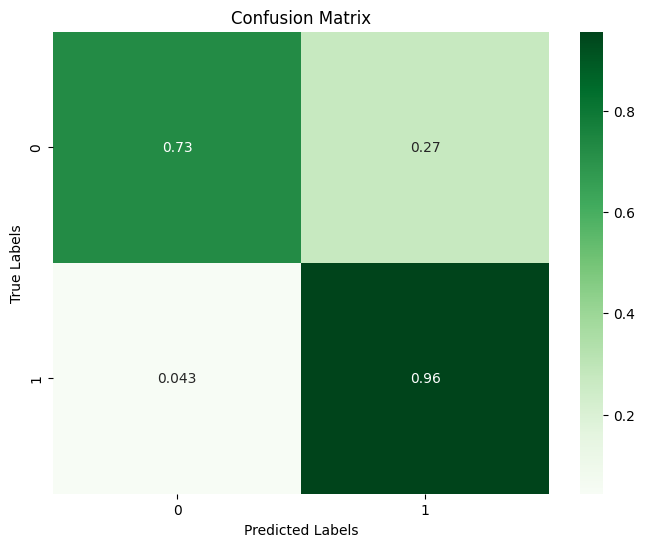

In [71]:
# print the confusion matrix
# cm = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_dtest, y_pred)
print("Confusion Matrix:")
print(cm)

# normalize the matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

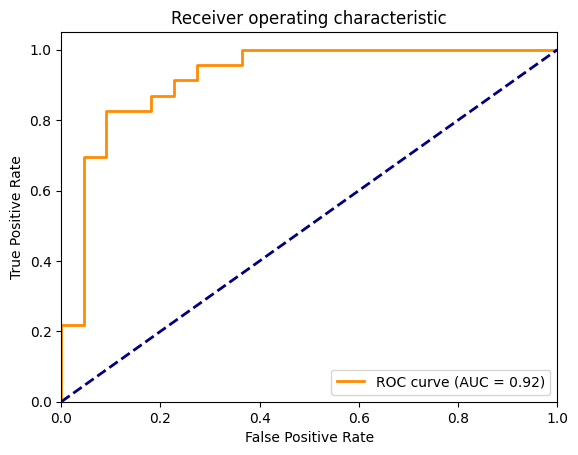

In [72]:
from sklearn.metrics import roc_curve, auc

# predict probabilities for test set
# y_pred_prob = model.predict(X_test_lstm)
y_pred_prob = model.predict(xfit)

# calculate fpr, tpr and threshold values
fpr, tpr, threshold = roc_curve(y_dtest, y_pred_prob)

# calculate AUC score
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

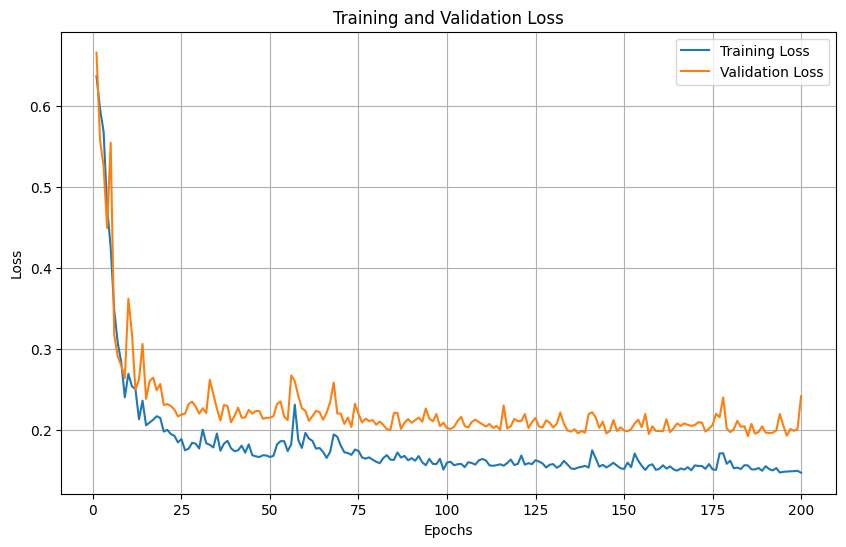

In [73]:
# Access training history metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [74]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


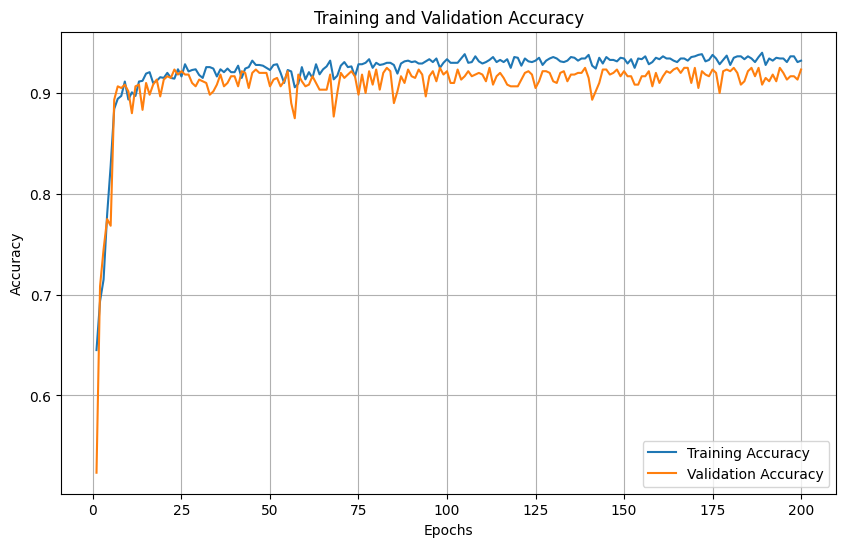

In [75]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(train_acc) + 1)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [76]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 13, 256)          133120    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 13, 256)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 13, 128)          164352    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 13, 128)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 13, 64)           41216     
 nal)                                                            
                                                      

In [77]:
#import shap

In [78]:
# explainer = shap.DeepExplainer(model, X_train_lstm)
# shap_values = explainer.shap_values(X_test_lstm)

In [79]:
# shap.initjs()
# # Assuming you want to visualize the explanations for the first example
# shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test_lstm[0])

In [1]:
print("SHAP version is:", shap.__version__)
print("Tensorflow version is:", tf.__version__)

NameError: name 'shap' is not defined